In [1]:
import os

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

pd.options.mode.chained_assignment = None

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")

In [2]:
data_folder = '/Users/alex/Workspace/Datasets/OlistEcommercePublicDataset'

orders_df = pd.read_csv(os.path.join(data_folder, 'olist_orders_dataset.csv'))
reviews_df = pd.read_csv(os.path.join(data_folder, 'olist_order_reviews_dataset.csv'))
products_df = pd.read_csv(os.path.join(data_folder, 'olist_products_dataset.csv'))
order_items_df = pd.read_csv(os.path.join(data_folder, 'olist_order_items_dataset.csv'))
customer_df = pd.read_csv(os.path.join(data_folder, 'olist_customers_dataset.csv'))
cat_name_translation =  pd.read_csv(os.path.join(data_folder, 'product_category_name_translation.csv'))

dfs = [orders_df, reviews_df, products_df, order_items_df, customer_df]

In [3]:
# Converting ID columns from 'object' type to string
for df in dfs:
    for column, ctype in zip(df.columns, df.dtypes):
        if ctype == 'object':
            df[column] = df[column].astype("string")

unique_id_df = pd.merge(orders_df[['order_id', 'customer_id']], customer_df[['customer_id', 'customer_unique_id']], on=['customer_id'], how='inner')
product_and_order_id_df = pd.merge(orders_df[['order_id', 'customer_id', 'order_purchase_timestamp']], order_items_df[['order_id', 'product_id']], on=['order_id'], how='inner')
user_product_order_id_df = pd.merge(unique_id_df, product_and_order_id_df, on=['order_id', 'customer_id'], how='inner')
final_df = pd.merge(user_product_order_id_df, reviews_df[['order_id', 'review_score']], on=['order_id'], how='inner').drop(['customer_id', 'order_id'], axis=1)

tmp_short_df = final_df.head(2000)
selection = tmp_short_df.customer_unique_id.unique().tolist()
final_df_short = final_df[pd.DataFrame(final_df.customer_unique_id.tolist()).isin(selection).any(1).values]
final_df_short.head()

,customer_unique_id,order_purchase_timestamp,product_id,review_score
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,4
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,4
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,5
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,5
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,5


In [4]:
products_df_short = products_df[products_df['product_id'].isin(final_df['product_id'])][['product_id', 'product_category_name']]
products_df_short.head()

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas


In [5]:
order_items_df_short = order_items_df[order_items_df['product_id'].isin(final_df['product_id'])][['product_id', 'price', 'freight_value']]
order_items_df_short['product_value'] = order_items_df_short['price'] - order_items_df_short['freight_value']
order_items_df_short.head()

,product_id,price,freight_value,product_value
0,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,45.61
1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,219.97
2,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,181.13
3,7634da152a4610f1595efa32f14722fc,12.99,12.79,0.20
4,ac6c3623068f30de03045865e4e10089,199.90,18.14,181.76


In [6]:
earnings = order_items_df_short['product_value'].sum()
freight_cost = order_items_df_short['freight_value'].sum()
total_money = order_items_df_short['price'].sum()

print(f"Earnings: {order_items_df_short['product_value'].sum()}")
print(f"Freight cost: {order_items_df_short['freight_value'].sum()}")
print(f"Price sum: {order_items_df_short['price'].sum()}")

Earnings: 11312170.430000002
Freight cost: 2247540.04
Price sum: 13559710.469999999


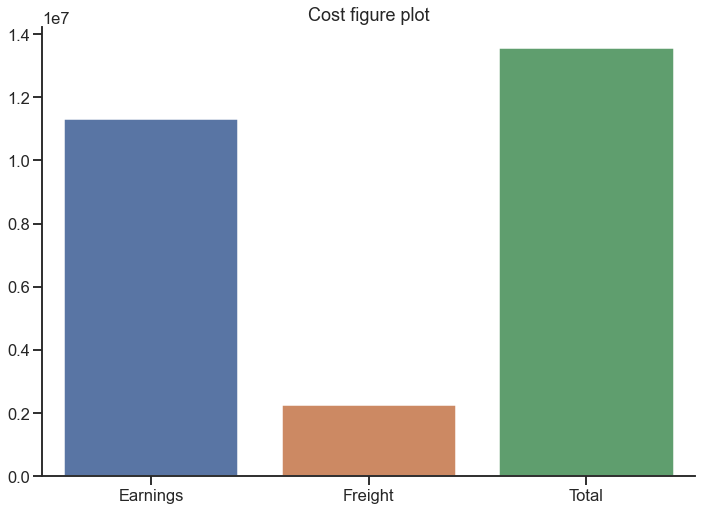

In [7]:
barplot = sns.barplot(x=["Earnings", "Freight", "Total"], y=[earnings, freight_cost, total_money])

sns.despine(ax=barplot)
barplot.set(title='Cost figure plot');

In [8]:
price_ordertime_id = pd.merge(user_product_order_id_df, order_items_df, on=['product_id', 'order_id'], how='inner')
price_ordertime_id = price_ordertime_id[['order_purchase_timestamp', 'price', 'freight_value']]
price_ordertime_id['order_purchase_timestamp'] = pd.to_datetime(price_ordertime_id['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S').apply(lambda x: x.strftime('%Y-%m'))
price_ordertime_id['order_purchase_year'] = pd.to_datetime(price_ordertime_id['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S').apply(lambda x: x.strftime('%Y'))
price_ordertime_id['order_purchase_month'] = pd.to_datetime(price_ordertime_id['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S').apply(lambda x: x.strftime('%m'))
price_ordertime_id.head()

,order_purchase_timestamp,price,freight_value,order_purchase_year,order_purchase_month
0,2017-10,29.99,8.72,2017,10
1,2018-07,118.70,22.76,2018,07
2,2018-08,159.90,19.22,2018,08
3,2017-11,45.00,27.20,2017,11
4,2018-02,19.90,8.72,2018,02


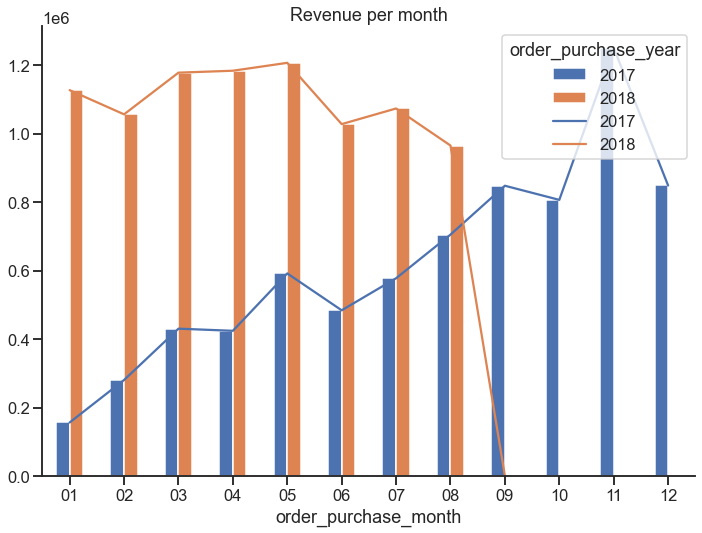

In [19]:
price_ordertime_id_filtered = price_ordertime_id[price_ordertime_id['order_purchase_year'] > '2016']
month_year_revenue = price_ordertime_id_filtered.groupby(['order_purchase_year', 'order_purchase_month']).sum().reset_index().pivot(index='order_purchase_month', columns='order_purchase_year')
barplot_2 = month_year_revenue['price'].plot(kind='bar')
barplot_3 = month_year_revenue['price'].plot(ax=barplot_2)

sns.despine(ax=barplot_2)
# sns.despine(ax=barplot_3)
barplot_2.set(title='Revenue per month');

In [ ]:
# Localization = geographic position clustering
# Weight ratings based on number of reviews per product

In [140]:
order_geo = pd.merge(orders_df, customer_df, on='customer_id', how='inner')[['order_id', 'customer_id', 'customer_unique_id', 'customer_city', 'customer_state']]
order_geo_items = pd.merge(order_geo, order_items_df, on='order_id', how='inner')[['order_id', 'customer_id', 'customer_unique_id', 'customer_city', 'customer_state', 'product_id', 'price']]
order_geo_items_category = pd.merge(order_geo_items, products_df[['product_id', 'product_category_name']], on='product_id', how='inner')[['customer_city', 'customer_state', 'product_category_name', 'price']]

portuguese_cat_names = cat_name_translation.to_dict()['product_category_name']
english_cat_names = cat_name_translation.to_dict()['product_category_name_english']
translate_dict = {}

for p_key in portuguese_cat_names:
    if portuguese_cat_names[p_key] not in translate_dict:
        translate_dict[portuguese_cat_names[p_key]] = english_cat_names[p_key]

order_geo_items_category['product_category_name'] = order_geo_items_category['product_category_name'].map(translate_dict)

order_geo_items_category.replace('são paulo', 'sao paulo')

order_geo_items_category.head()

,customer_city,customer_state,product_category_name,price
0,sao paulo,SP,housewares,29.99
1,sao paulo,SP,housewares,29.99
2,sao paulo,SP,housewares,29.99
3,florianopolis,SC,housewares,29.99
4,barreiras,BA,perfumery,118.70


In [141]:
orders_per_category = order_geo_items_category.groupby(['customer_city', 'product_category_name']).size().reset_index(name='count').sort_values(by='count', ascending=False)
orders_per_category.head(20)

,customer_city,product_category_name,count
21824,sao paulo,bed_bath_table,1984
21860,sao paulo,health_beauty,1753
21881,sao paulo,sports_leisure,1397
21866,sao paulo,housewares,1321
21856,sao paulo,furniture_decor,1268
21832,sao paulo,computers_accessories,1227
19062,rio de janeiro,bed_bath_table,854
21886,sao paulo,watches_gifts,844
21885,sao paulo,toys,658
21884,sao paulo,telephony,620


In [144]:
ordered_orders_per_category = orders_per_category.groupby(['customer_city', 'product_category_name'])[['count']].max().sort_values(by='count', ascending=False).reset_index()
ordered_orders_per_category.head(10)

,customer_city,product_category_name,count
0,sao paulo,bed_bath_table,1984
1,sao paulo,health_beauty,1753
2,sao paulo,sports_leisure,1397
3,sao paulo,housewares,1321
4,sao paulo,furniture_decor,1268
5,sao paulo,computers_accessories,1227
6,rio de janeiro,bed_bath_table,854
7,sao paulo,watches_gifts,844
8,sao paulo,toys,658
9,sao paulo,telephony,620


In [138]:
top_city_category = {}
for idx, city in enumerate(ordered_orders_per_category['customer_city'].unique()):
    # print(city)
    # print(ordered_orders_per_category[ordered_orders_per_category['customer_city'] == city].iloc[0].values[1:])
    top_city_category[city] = {
        'product_category': ordered_orders_per_category[ordered_orders_per_category['customer_city'] == city].iloc[0].values[1],
        'nr_sales': ordered_orders_per_category[ordered_orders_per_category['customer_city'] == city].iloc[0].values[2]
    }

In [146]:
top_city_category['sao paulo']

{'product_category': 'bed_bath_table', 'nr_sales': 1984}